## Domain-Adversarial Neural Networks (DANN) 

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the data
data = pd.read_csv("wholevalue.csv")

In [ ]:
# Separate features and target
sensitive_attr = 'Gender'
target = 'Average Course Outcome Level'
X = data.drop(columns=[sensitive_attr, target])
y = data[target]
gender = data[sensitive_attr]


#### Encoding the values

In [4]:
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

In [5]:
# Normalizing the feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test, y_gender_train, y_gender_test = train_test_split(
    X_scaled, y, gender, test_size=0.2, random_state=42
)

In [ ]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32) 
y_test = torch.tensor(y_test.values, dtype=torch.float32)
y_gender_train = torch.tensor(y_gender_train.values, dtype=torch.long)  
y_gender_test = torch.tensor(y_gender_test.values, dtype=torch.long)

In [ ]:
# Hyperparameters
input_size = X_train.shape[1]  # Number of features
batch_size = 32
alpha = 1.0  # Weight for adversarial loss 

In [ ]:
# Model Definition
class DANN(nn.Module):
    def __init__(self, input_size):
        super(DANN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        self.label_regressor = nn.Sequential(
            nn.Linear(64, 1)  # Regression output for Average Course Outcome Level
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(64, 2),  # Gender classifier (binary: male or female)
            nn.Softmax(dim=1)
        )

    def forward(self, x, alpha=10.0):
        features = self.feature_extractor(x)

        # Domain Adversarial Training
        domain_out = self.domain_classifier(features)
        label_out = self.label_regressor(features)

        return label_out, domain_out

In [40]:
# Loss and Optimizer
label_criterion = nn.MSELoss()  # For regression task (Average Course Outcome Level)
domain_criterion = nn.CrossEntropyLoss()  # For binary gender classification
model = DANN(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
# DataLoader setup
train_dataset = TensorDataset(X_train, y_train, y_gender_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test, y_gender_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:
print("Demographics (Before Debiasing):")
print(pd.Series(y_gender_train.numpy()).value_counts())

Demographics (Before Debiasing):
0    123
1    107
Name: count, dtype: int64


#### Training

In [ ]:
for epoch in range(75): 
    for i, (X_batch, y_label_batch, y_gender_batch) in enumerate(train_loader):
        # Forward pass through the model
        label_out, domain_out = model(X_batch, alpha=alpha)

        # Calculate losses
        label_loss = label_criterion(label_out.squeeze(), y_label_batch)
        domain_loss = domain_criterion(domain_out, y_gender_batch)

        # Total loss and backward pass
        total_loss = label_loss + alpha * domain_loss 
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Track and print gender classification accuracy (post-debiasing)
        _, predicted_gender = torch.max(domain_out, 1)
        gender_accuracy = (predicted_gender == y_gender_batch).float().mean().item()

        if i % 100 == 0:  # Printing every 100 steps (for debugging)
            print(f"Epoch [{epoch}/{10}], Step [{i}/{len(train_loader)}], "
                  f"Label Loss: {label_loss.item():.4f}, Domain Loss: {domain_loss.item():.4f}, "
                  f"Gender Accuracy: {gender_accuracy:.4f}")

Epoch [0/10], Step [0/8], Label Loss: 0.4785, Domain Loss: 0.6348, Gender Accuracy: 0.6562
Epoch [1/10], Step [0/8], Label Loss: 0.6289, Domain Loss: 0.6389, Gender Accuracy: 0.7188
Epoch [2/10], Step [0/8], Label Loss: 0.3854, Domain Loss: 0.5590, Gender Accuracy: 0.8125
Epoch [3/10], Step [0/8], Label Loss: 0.5744, Domain Loss: 0.6056, Gender Accuracy: 0.6875
Epoch [4/10], Step [0/8], Label Loss: 0.8400, Domain Loss: 0.5321, Gender Accuracy: 0.8125
Epoch [5/10], Step [0/8], Label Loss: 0.4336, Domain Loss: 0.6020, Gender Accuracy: 0.6562
Epoch [6/10], Step [0/8], Label Loss: 0.6168, Domain Loss: 0.6619, Gender Accuracy: 0.5938
Epoch [7/10], Step [0/8], Label Loss: 0.1820, Domain Loss: 0.5773, Gender Accuracy: 0.7812
Epoch [8/10], Step [0/8], Label Loss: 0.4721, Domain Loss: 0.6648, Gender Accuracy: 0.5938
Epoch [9/10], Step [0/8], Label Loss: 0.7208, Domain Loss: 0.5332, Gender Accuracy: 0.8125
Epoch [10/10], Step [0/8], Label Loss: 0.2810, Domain Loss: 0.6040, Gender Accuracy: 0.781

In [54]:
# Monitor domain classifier accuracy (gender classification)
gender_accuracy = (predicted_gender == y_gender_batch).float().mean().item()
print(f"Gender Accuracy: {gender_accuracy:.4f}")

Gender Accuracy: 0.8333


In [ ]:
# After Debiasing - Print model performance
print("\nDemographics (After Debiasing):")
print(pd.Series(y_gender_train.numpy()).value_counts())  # Gender distribution after debiasing
print("\nModel Performance After Debiasing:")


Demographics (After Debiasing):
0    123
1    107
Name: count, dtype: int64

Model Performance After Debiasing:


In [56]:
# Gender prediction accuracy (this should be low if debiasing is successful)
predicted_gender_all = []
y_gender_test_all = []

In [ ]:
# Loop through the test dataset in batches to calculate the accuracy
with torch.no_grad():
    for X_batch, y_label_batch, y_gender_batch in test_loader:
        _, domain_out = model(X_batch, alpha=alpha)
        _, predicted_gender_batch = torch.max(domain_out, 1)
        predicted_gender_all.append(predicted_gender_batch)
        y_gender_test_all.append(y_gender_batch)

In [58]:
# Convert lists to tensors
predicted_gender_all = torch.cat(predicted_gender_all, dim=0)
y_gender_test_all = torch.cat(y_gender_test_all, dim=0)

# Compute the gender prediction accuracy
gender_accuracy_after = (predicted_gender_all == y_gender_test_all).float().mean().item()
print(f"Gender Prediction Accuracy (after debiasing): {gender_accuracy_after:.4f}")

Gender Prediction Accuracy (after debiasing): 0.6379


In [59]:
# Course outcome prediction performance (main task)
# model's predictions match the actual course outcomes for the test data
with torch.no_grad():
    label_out_all = []
    for X_batch, y_label_batch, y_gender_batch in test_loader:
        label_out, _ = model(X_batch, alpha=alpha)
        label_out_all.append(label_out)

# Concatenate all outputs and calculate accuracy for course outcome prediction
label_out_all = torch.cat(label_out_all, dim=0)
course_outcome_pred = label_out_all.squeeze()
course_outcome_accuracy = (course_outcome_pred.round() == y_test).float().mean().item()
print(f"Course Outcome Prediction Accuracy: {course_outcome_accuracy:.4f}")

Course Outcome Prediction Accuracy: 0.4655


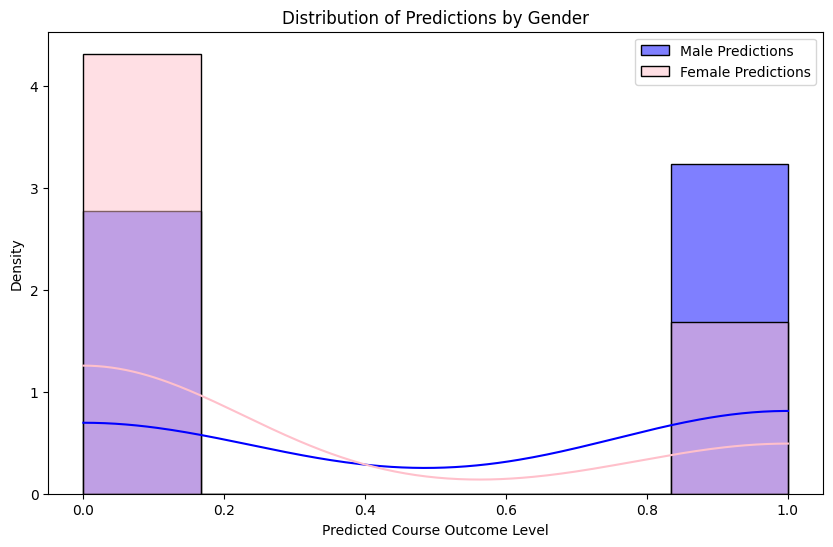

In [60]:
# Plot distributions of predictions for each gender to visualize demographic parity
plt.figure(figsize=(10, 6))
sns.histplot(predicted_gender_all[y_gender_test_all == 1], color='blue', label='Male Predictions', kde=True, stat="density")
sns.histplot(predicted_gender_all[y_gender_test_all == 0], color='pink', label='Female Predictions', kde=True, stat="density")
plt.title("Distribution of Predictions by Gender")
plt.xlabel("Predicted Course Outcome Level")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
def demographic_parity(protected_attribute, predictions):
    protected_attribute = protected_attribute.float()
    predictions = predictions.float()
    
    # Assuming 1 as the positive prediction class
    privileged_group = predictions[protected_attribute == 1]  # '1' represents females
    unprivileged_group = predictions[protected_attribute == 0]  # '0' represents males
   
    privileged_rate = privileged_group.mean()
    unprivileged_rate = unprivileged_group.mean()

    return privileged_rate, unprivileged_rate


In [62]:
# Demographic Parity (Before and After)
# Calculate and display demographic parity before training
privileged_rate_before, unprivileged_rate_before = demographic_parity(y_gender_test_all, predicted_gender_all)
print(f"Demographic Parity (Before): {privileged_rate_before:.2f} (male), {unprivileged_rate_before:.2f} (female)")

# Disparate Impact (Before)
disparate_impact_before = privileged_rate_before / unprivileged_rate_before
print(f"Disparate Impact (Before): {disparate_impact_before:.2f} (male to female ratio)")


Demographic Parity (Before): 0.54 (male), 0.28 (female)
Disparate Impact (Before): 1.91 (male to female ratio)


In [63]:
# After Training
privileged_rate_after, unprivileged_rate_after = demographic_parity(y_gender_test_all, predicted_gender_all)
print(f"Demographic Parity (After): {privileged_rate_after:.2f} (male), {unprivileged_rate_after:.2f} (female)")

# Disparate Impact (After)
disparate_impact_after = privileged_rate_after / unprivileged_rate_after
print(f"Disparate Impact (After): {disparate_impact_after:.2f} (male to female ratio)")

Demographic Parity (After): 0.54 (male), 0.28 (female)
Disparate Impact (After): 1.91 (male to female ratio)
